# HW3P2: Speech Recognition with Neural Networks: Utterance to Phoneme Mapping


# Schedule:
- Checkpoint Submission (DUE 31 October 2025 @ 11:59PM EST)
- Final Submission (DUE 7 November 2025 @ 11:59PM EST | Slack Deadline 14 November 2025 @ 11:59PM EST)
- Code Submission (DUE 9 November 2025 @ 11:59PM EST OR Day-of Slack submission)

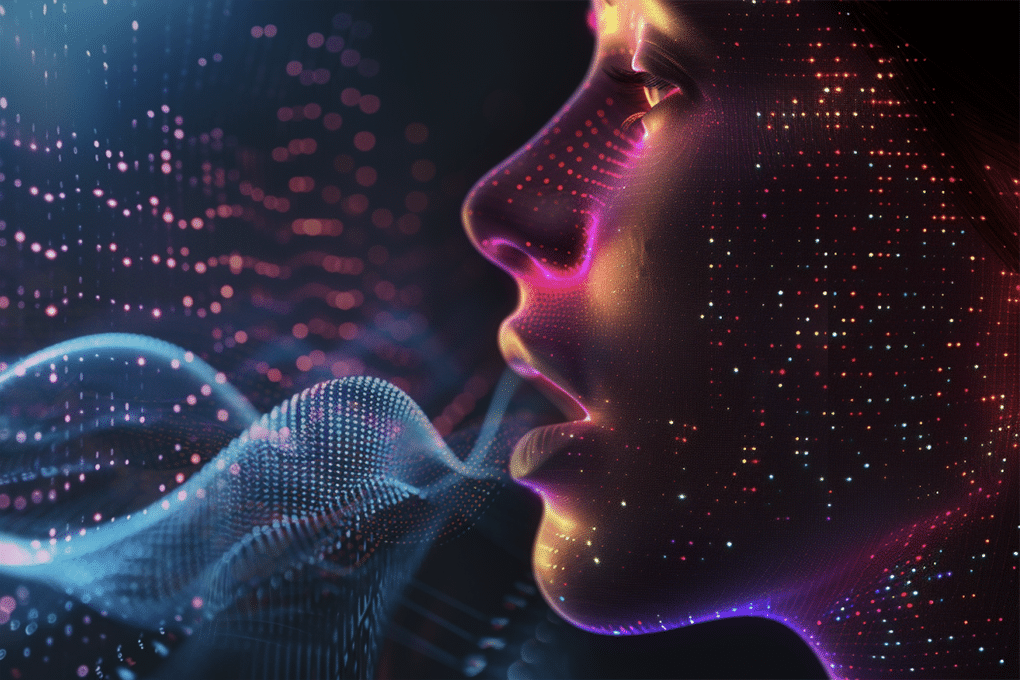

## Requirement Acknowledgement
Setting the below flag to True indicates full understanding and acceptance of the following:
1. Slack days may ONLY be used on P2 FINAL (not checkpoint) submission. I.e. you may use slack days to submit final P2 kaggle scores (such as this one) later on the **SLACK KAGGLE COMPETITION** at the expense of your Slack days.
2. The final autolab **code submission is due 48 hours after** the conclusion of the Kaggle Deadline (or, the same day as your final Kaggle submission).
3. We will require your kaggle username here, and then we will pull your official PRIVATE kaggle leaderboard score. This submission may result in slight variance in scores/code, but we will check for acceptable discrepancies. Any discrepancies related to modifying the submission code (at the bottom of the notebook) will result in an AIV.
4. You are NOT allowed to use any code that will pre-load models (such as those from Hugging Face, etc.).
   You MAY use models described by papers or articles, but you MUST implement them yourself through fundamental PyTorch operations (i.e. Linear, Conv2d, etc.).
5. You are NOT allowed to use any external data/datasets at ANY point of this assignment.
6. You may work with teammates to run ablations/experiments, BUT you must submit your OWN code and your OWN results.
7. Failure to comply with the prior rules will be considered an Academic Integrity Violation (AIV).
8. Late submissions MUST be submitted through the Slack Kaggle (see writeup for details). Any submissions made to the regular Kaggle after the original deadline will NOT be considered, no matter how many slack days remain for the student.

In [1]:
ACKNOWLEDGED = True #TODO: Only set Acknowledged to True if you have read the above acknowlegements and agree to ALL of them.

In this assignment, you'll build a sequence-to-sequence model that maps speech utterances to phoneme sequences. You'll implement a recurrent neural network architecture that processes speech feature vectors (MFCCs) and outputs corresponding phoneme sequences.

## Key Components

- **Data Processing**: Work with Mel-Frequency Cepstral Coefficients (MFCCs) and handle variable-length sequences through padding and packing
- **Neural Network Architecture**: Implement a model using basic CNNs for feature extraction, BiLSTMs for sequential modeling, and optional pyramidal BiLSTMs for downsampling
- **CTC Loss**: Train your model using Connectionist Temporal Classification to handle sequence alignment challenges
- **Decoding Strategies**: Explore both greedy search and beam search for phoneme sequence generation
- **Evaluation**: Use Levenshtein Distance to measure the accuracy of your predicted phoneme sequences
- **Submission**: Submit your results on kaggle for final evaluation.

This assignment will give you practical experience with sequence modeling techniques essential to speech recognition systems while exploring various architectural choices and optimization strategies.

# **SET-UP**

Firstly, join the kaggle competition. (https://www.kaggle.com/t/2a94d2c1488a4798b02012f37682d5d8)

## **Google Colab Users**

### Step 1. Environment Setup

In [2]:
import torch
import random
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import wandb
import torchaudio.transforms as tat
from torchaudio.models.decoder import cuda_ctc_decoder
import Levenshtein

from sklearn.metrics import accuracy_score
import gc

import glob

import zipfile
from tqdm.auto import tqdm
import os
import datetime


import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


/home/agcheria/miniconda3/envs/IDL/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step 2. Download Data

If you are using Kaggle, follow these steps to add the dataset directly to your notebook:
1. Join the kaggle competition (https://www.kaggle.com/t/2a94d2c1488a4798b02012f37682d5d8)
2. Open your **Kaggle Notebook**.  
3. Navigate to **Notebook → Input**.  
4. Click **Add Input**.  
5. Choose "Competition Datasets" and "Your work", and then you'll be able to see the competiation "11785-hw-3-p-2-speech-recognition-fall-2025"
6. Click the **➕ (plus sign)** to add the dataset to your notebook.

## **PSC Users**

### 1️⃣ **Step 1: Set Up the Environment on Bridges2**

❗️⚠️ For this homework, we are **providing shared Datasets and a shared Conda environment** for the entire class.

❗️⚠️ So for PSC users, **do not download the data yourself** and **do not need to manually install the packages**!

Follow these steps to set up the environment and start a Jupyter notebook on Bridges2:

To run your notebook more efficiently on PSC, we need to use a **Jupyter Server** hosted on a compute node.

You can use your prefered way of connecting to the Jupyter Server. **The recommended way is to connect in VSCode.**

Follow the instructions below.

#### **1.1 SSH into Bridges2**
1）Open VS Code and click on the `Extensions` icon in the left sidebar. Make sure the "**Remote - SSH**" extension is installed.

2）Open the command palette (**Shift+Command+P** on Mac, **Ctrl+Shift+P** on Windows). A search box will appear at the top center. Choose `"Remote-SSH: Add New SSH Host"`, then enter:

```bash
ssh <your_username>@bridges2.psc.edu #change <your_username> to your username
```

Next, choose `"/Users/<your_username>/.ssh/config"` as the config file. A dialog will appear in the bottom right saying "Host Added". Click `"Connect"`, and then enter your password.

(Note: After adding the host once, you can later use `"Remote-SSH: Connect to Host"` and select "bridges2.psc.edu" from the list.)

3）Once connected, click `"Explorer"` in the left sidebar > "Open Folder", and navigate to your home directory under the project grant:
```bash
/jet/home/<your_username>  #change <your_username> to your username
```

4）You can now drag your notebook files directly into the right-hand pane (your remote home directory), or upload them using `scp` into your folder.

> ❗️⚠️ The following steps should be executed in the **VSCode integrated terminal**.

#### **1.2 Navigate to Your Directory**
Make sure to use this `/jet/home/<your_username>` as your working directory, since all subsequent operations (up to submission) are based on this path.
```bash
cd /jet/home/<your_username>  #change <your_username> to your username
```

#### **1.3 Request a Compute Node**
```bash
interact -p GPU-shared --gres=gpu:v100-32:1 -t 8:00:00 -A cis250019p
```

#### **1.4 Load the Anaconda Module**
```bash
module load anaconda3
```

#### **1.5 Activate the provided HW3 Environment**
```bash
conda deactivate # First, deactivate any existing Conda environment
conda activate /ocean/projects/cis250019p/mzhang23/TA/HW3P2/envs/hw3p2_env && export PYTHONNOUSERSITE=1
```

##### Optional:
If you prefer, you can export the kernel manually using the command below.
This will register your HW3 environment (hw3p2_env) in the Jupyter, so you can directly select it in the notebook’s top-right corner via `Select Kernel → Jupyter Kernel → idl_hw3p2`. In that case, you don’t need to run Step 1.6 (--no-browser launch).
```bash
python -m ipykernel install --user --name hw3p2_env --display-name "Python (idl_hw3p2)"
```

#### **1.6 Start Jupyter Notebook**
Before launching Jupyter Notebook, make sure you activate your virtual environment (Step 1.5) in the same terminal where you will run the `--no-browser` command. Otherwise, the kernel associated with that environment will not appear in Jupyter.

Launch Jupyter Notebook:
```bash
jupyter notebook --no-browser --ip=0.0.0.0
```

Go to **Kernel** → **Select Another Kernel** → **Existing Jupyter Server** (select the idl_hw3p2 virtual environment to use)
  
Enter the URL of the Jupyter Server:```http://{hostname}:{port}/tree?token={token}```
   
   *(Usually, this URL appears in the terminal output after you run `jupyter notebook --no-browser --ip=0.0.0.0`, in a line like:  “Jupyter Server is running at: http://...”)*

   - eg: `http://v011.ib.bridges2.psc.edu:8888/tree?token=e4b302434e68990f28bc2b4ae8d216eb87eecb7090526249`  (change accordingly)


> **Note**: Replace `{hostname}`, `{port}` and `{token}` with your actual values from the Jupyter output.

#### **1.7 Import dependencies**

After launching the Jupyter notebook, you can run the cells directly inside the notebook — no need to use the terminal for the remaining steps.

First, import the dependencies.  
(*If you followed the previous steps and correctly activated our shared `hw3p2` environment, you do **not** need to install anything manually.*)

In [3]:
import yaml
with open("config.yaml") as file:
    config = yaml.safe_load(file)

In [4]:
config

{'subset': 1.0,
 'learning_rate': 0.001,
 'epochs': 100,
 'train_beam_width': 3,
 'test_beam_width': 10,
 'mfcc_features': 28,
 'input_size': 28,
 'embed_size': 256,
 'batch_size': 128,
 'encoder dropout': 0.2,
 'lstm dropout': 0.2,
 'decoder dropout': 0.2,
 'wandb': True,
 'Name': 'Student_Name'}

- You will need to set the root path to your `hw3p2_data` folder. This will depend on your setup. e.g.,
  - `Colab:`: `"/content/11785-hw3p2"`
  - `Kaggle:`: `"/kaggle/input/11785-hw-3-p-2-speech-recognition-fall-2025/11785-hw3p2"`
  - `PSC`: `"/ocean/projects/cis250019p/mzhang23/TA/HW3P2/hw3p2_data/11785-hw3p2"`

In [5]:
BATCH_SIZE = config["batch_size"] # Define batch size from config
root = "/home/agcheria/idl_assignment_Fall_2025_1/HW3/HW3P2/11785-hw3p2" # Specify the directory to your root based on your environment: Google Colab, Kaggle, or PSC

# Setup Vocabulary (DO NOT MODIFY)

In [6]:
# ARPABET PHONEME MAPPING
# DO NOT CHANGE

CMUdict_ARPAbet = {
    "" : " ",
    "[SIL]": "-", "NG": "G", "F" : "f", "M" : "m", "AE": "@",
    "R"    : "r", "UW": "u", "N" : "n", "IY": "i", "AW": "W",
    "V"    : "v", "UH": "U", "OW": "o", "AA": "a", "ER": "R",
    "HH"   : "h", "Z" :
     "z", "K" : "k", "CH": "C", "W" : "w",
    "EY"   : "e", "ZH": "Z", "T" : "t", "EH": "E", "Y" : "y",
    "AH"   : "A", "B" : "b", "P" : "p", "TH": "T", "DH": "D",
    "AO"   : "c", "G" : "g", "L" : "l", "JH": "j", "OY": "O",
    "SH"   : "S", "D" : "d", "AY": "Y", "S" : "s", "IH": "I",
    "[SOS]": "[SOS]", "[EOS]": "[EOS]"
}


CMUdict = list(CMUdict_ARPAbet.keys())
ARPAbet = list(CMUdict_ARPAbet.values())

PHONEMES = CMUdict[:-2] #To be used for mapping original transcripts to integer indices
LABELS = ARPAbet[:-2] #To be used for mapping predictions to strings

OUT_SIZE = len(PHONEMES) # Number of output classes
print("Number of Phonemes:", OUT_SIZE)

# Indexes of BLANK and SIL phonemes
BLANK_IDX=CMUdict.index('')
SIL_IDX=CMUdict.index('[SIL]')

print("Index of Blank:", BLANK_IDX)
print("Index of [SIL]:", SIL_IDX)

Number of Phonemes: 41
Index of Blank: 0
Index of [SIL]: 1


### Sample data inspection & sanity check

In [7]:
test_mfcc = f"{root}/train-clean-100/mfcc/103-1240-0000.npy"
test_transcript = f"{root}/train-clean-100/transcript/103-1240-0000.npy"

mfcc = np.load(test_mfcc)
transcript = np.load(test_transcript)[1:-1] #Removed [SOS] and [EOS]

print("MFCC Shape:", mfcc.shape)
print("\nMFCC:\n", mfcc)
print("\nTranscript shape:", transcript.shape)

print("\nOriginal Transcript:\n", transcript)

# map the loaded transcript (from phonemes representation) to corresponding labels representation
mapped_transcript = [CMUdict_ARPAbet[k] for k in transcript]
print("\nTranscript mapped from PHONEMES representation to LABELS representation:\n", mapped_transcript)

# Mapping list of PHONEMES to list of Integer indexes
map = {k: i for i, k in enumerate(PHONEMES)}
print("\nMapping list of PHONEMES to list of Integer indexes:\n", map)

MFCC Shape: (1404, 28)

MFCC:
 [[ 1.10582151e+01  1.28330450e+01  2.10689220e+01 ... -8.75406042e-02
   7.30623007e-02  9.48924713e+01]
 [ 1.16850815e+01  1.38329487e+01  2.19087906e+01 ... -1.39180899e-01
  -6.15991093e-02  9.55670319e+01]
 [ 1.11048431e+01  1.67276516e+01  2.28863831e+01 ... -4.03698802e-01
   8.09250996e-02  9.54314651e+01]
 ...
 [ 2.62413955e+00 -1.26996317e+01  2.79472313e+01 ... -1.49060452e+00
  -2.67574161e-01  1.16191261e+02]
 [ 3.05713993e-02 -1.20763254e+01  2.60116520e+01 ... -8.54688883e-01
  -1.20284989e-01  1.17127373e+02]
 [-1.33604801e+00 -1.17101593e+01  2.44703121e+01 ... -9.30283189e-01
  -8.16672146e-02  1.18280014e+02]]

Transcript shape: (145,)

Original Transcript:
 ['[SIL]' 'CH' 'AE' 'P' 'T' 'ER' 'W' 'AH' 'N' '[SIL]' 'M' 'IH' 'S' 'IH' 'Z'
 'R' 'EY' 'CH' 'AH' 'L' 'IH' 'N' 'D' 'IH' 'Z' 'S' 'ER' 'P' 'R' 'AY' 'Z'
 'D' '[SIL]' 'M' 'IH' 'S' 'IH' 'Z' 'R' 'EY' 'CH' 'AH' 'L' 'IH' 'N' 'D'
 '[SIL]' 'L' 'AY' 'V' 'D' '[SIL]' 'JH' 'AH' 'S' 'T' 'W' 'EH' 'R' '

# Dataset and Dataloader

### Train Data

In [8]:
class AudioDataset(torch.utils.data.Dataset):

    # For this homework, we give you full flexibility to design your data set class.
    # Hint: The data from HW1 is very similar to this HW

    #TODO
    def __init__(self, root, partition="train-clean-100", train=True):
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''

        self.PHONEMES = PHONEMES
        self.subset = config['subset']
        self.train = train  # Flag to control augmentation
        self.freq_masking = tat.FrequencyMasking(freq_mask_param=10)
        self.time_masking = tat.TimeMasking(time_mask_param=10)

        # TODO
        # Define the directories containing MFCC and transcript files
        self.mfcc_dir = os.path.join(root, partition, 'mfcc')
        self.transcript_dir = os.path.join(root, partition, 'transcript')

        # List all files in the directories. Remember to sort the files
        self.mfcc_files = sorted(os.listdir(self.mfcc_dir)  )
        self.transcript_files = sorted(os.listdir(self.transcript_dir))

        # Compute size of data subset
        subset_size = int(self.subset * len(self.mfcc_files))

        # Select subset of data to use
        self.mfcc_files = self.mfcc_files[:subset_size]
        self.transcript_files = self.transcript_files[:subset_size]

        assert(len(self.mfcc_files) == len(self.transcript_files))

        #TODO
        # WHAT SHOULD THE LENGTH OF THE DATASET BE?
        self.length = len(self.mfcc_files)

        #TODO
        # CREATE AN ARRAY TO STORE ALL PROCESSED MFCCS AND TRANSCRIPTS
        # LOAD ALL MFCCS AND CORRESPONDING TRANSCRIPTS AND DO THE NECESSARY PRE-PROCESSING
          # HINTS:
          # WHAT NORMALIZATION TECHNIQUE DID YOU USE IN HW1? CAN WE USE IT HERE?
          # REMEMBER TO REMOVE [SOS] AND [EOS] FROM TRANSCRIPTS
        '''
        You may decide to do this in __getitem__ if you wish.
        However, doing this here will make the __init__ function take the load of
        loading the data, and shift it away from training.
        '''
        self.mfccs = []
        self.transcripts = []
        for i in tqdm(range(len(self.mfcc_files))):

            # TODO: Load a single mfcc. Hint: Use numpy
            mfcc             = np.load(os.path.join(self.mfcc_dir, self.mfcc_files[i]))
            # TODO: Do Cepstral Normalization of mfcc along the Time Dimension (Think about the correct axis)
            mfccs_normalized = (mfcc - np.mean(mfcc, axis=0)) /( np.std(mfcc, axis=0)+1e-6)

            # Convert mfcc to tensor
            mfccs_normalized = torch.tensor(mfccs_normalized, dtype=torch.float32)

            # TODO: Load the corresponding transcript
            # Remove [SOS] and [EOS] from the transcript
            # (Is there an efficient way to do this without traversing through the transcript?)
            # Note that SOS will always be in the starting and EOS at end, as the name suggests.
            transcript = np.load(f'{self.transcript_dir}/{self.transcript_files[i]}')[1:-1]
            # The available phonemes in the transcript are of string data type
            # But the neural network cannot predict strings as such.
            # Hence, we map these phonemes to integers

            # TODO: Map the phonemes to their corresponding list indexes in self.phonemes
            transcript_indices = [self.PHONEMES.index(phoneme) for phoneme in transcript]
            # Now, if an element in the transcript is 0, it means that it is 'SIL' (as per the above example)

            # Convert transcript to tensor
            transcript_indices = torch.tensor(transcript_indices, dtype=torch.int64)

            # Append each mfcc to self.mfcc, transcript to self.transcript
            self.mfccs.append(mfccs_normalized)
            self.transcripts.append(transcript_indices)
        

        #TODO
        # HOW CAN WE REPRESENT PHONEMES? CAN WE CREATE A MAPPING FOR THEM?
        # HINT: TENSORS CANNOT STORE NON-NUMERICAL VALUES OR STRINGS
        self.map = {k: i for i, k in enumerate(PHONEMES)}
        



    def __len__(self):

        '''
        TODO: What do we return here?
        '''

        return self.length


    def __getitem__(self, ind):

        '''
        TODO: RETURN THE MFCC COEFFICIENTS AND ITS CORRESPONDING LABELS

        If you didn't do the loading and processing of the data in __init__,
        do that here.

        Once done, return a tuple of features and labels.

        '''

        # Use preloaded and normalized tensors from __init__
        return self.mfccs[ind], self.transcripts[ind]


    def collate_fn(self,batch):
        '''
        TODO:
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features,
            and lengths of labels.
        '''

        # Extract batch of input MFCCs and batch of output transcripts separately
        batch_mfcc = [item[0] for item in batch]
        batch_transcript = [item[1] for item in batch]

        # Store original lengths of the MFCCS and transcripts in the batches
        lengths_mfcc = [item.shape[0] for item in batch_mfcc]
        lengths_transcript = [item.shape[0] for item in batch_transcript]

        # Apply SpecAugment BEFORE padding, and only on training data
        if self.train:
            aug_mfcc = []
            for mfcc in batch_mfcc:
                # mfcc shape: (T, F) -> need (1, F, T) for torchaudio transforms
                mfcc_aug = mfcc.T.unsqueeze(0)  # (1, F, T)
                mfcc_aug = self.time_masking(self.freq_masking(mfcc_aug)).squeeze(0)  # (F, T)
                aug_mfcc.append(mfcc_aug.T)  # back to (T, F)
            batch_mfcc = aug_mfcc

        # Pad the MFCC sequences and transcripts
        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        # Note: (resulting shape of padded MFCCs: [batch, time, freq])
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True)
        batch_transcript_pad = pad_sequence(batch_transcript, batch_first=True)

        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

### Test Data

In [9]:

   # TODO
# Food for thought -> Do you need to apply transformations in this test dataset class?
class AudioDatasetTest(torch.utils.data.Dataset):
    def __init__(self, root, partition="test-clean"):
        self.root = root
        self.partition = partition
        self.mfcc_dir = os.path.join(root, partition, 'mfcc')
        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))
        self.length = len(self.mfcc_files)
        self.mfccs = []
        for mfcc_file in self.mfcc_files:
            mfcc = np.load(os.path.join(self.mfcc_dir, mfcc_file))
            mfcc=(mfcc-np.mean(mfcc, axis=0))/(np.std(mfcc, axis=0) + 1e-6)
            self.mfccs.append(torch.tensor(mfcc, dtype=torch.float32))
        self.map = {k: i for i, k in enumerate(PHONEMES)}
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, ind):
        mfcc = self.mfccs[ind]
        return mfcc
    def collate_fn(self, batch):
        xs = batch  # list of (T, F) tensors
        x_lengths = torch.as_tensor([x.shape[0] for x in xs], dtype=torch.long)
        x_padded  = pad_sequence(xs, batch_first=True)
        return x_padded, x_lengths

In [10]:
# To free up ram
import gc
gc.collect()

0

### Create Datasets & Data loaders

In [11]:
# Create objects for the dataset classes
train_data = AudioDataset(root=root, partition="train-clean-100", train=True)
val_data = AudioDataset(root=root, partition="train-clean-100", train=False)
test_data = AudioDatasetTest(root=root, partition="test-clean")

100%|██████████| 28539/28539 [00:07<00:00, 3638.76it/s]


In [12]:
# Do NOT forget to pass in the collate function as an argument while creating the dataloader
train_loader = DataLoader(train_data,num_workers=4, pin_memory=True, shuffle=True, batch_size=config['batch_size'], collate_fn=train_data.collate_fn)

val_loader = DataLoader(val_data, num_workers=0, pin_memory=True, shuffle=False, batch_size=config['batch_size'], collate_fn=val_data.collate_fn)

test_loader = DataLoader(test_data, num_workers=0, pin_memory=True, shuffle=False, batch_size=config['batch_size'], collate_fn=test_data.collate_fn)

print("Batch size: ", config['batch_size'])
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  128
Train dataset samples = 28539, batches = 223
Val dataset samples = 28539, batches = 223
Test dataset samples = 2620, batches = 21


In [13]:
# sanity check
for data in train_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, ly.shape)
    break

torch.Size([128, 1677, 28]) torch.Size([128, 199]) torch.Size([128]) torch.Size([128])


# Visualize Data

Note: In the visualized graph, do not confuse padded regions of the MFCC sequences with time/freq augmentation masks. Remember all MFCCs were padded to the maximum sequence length

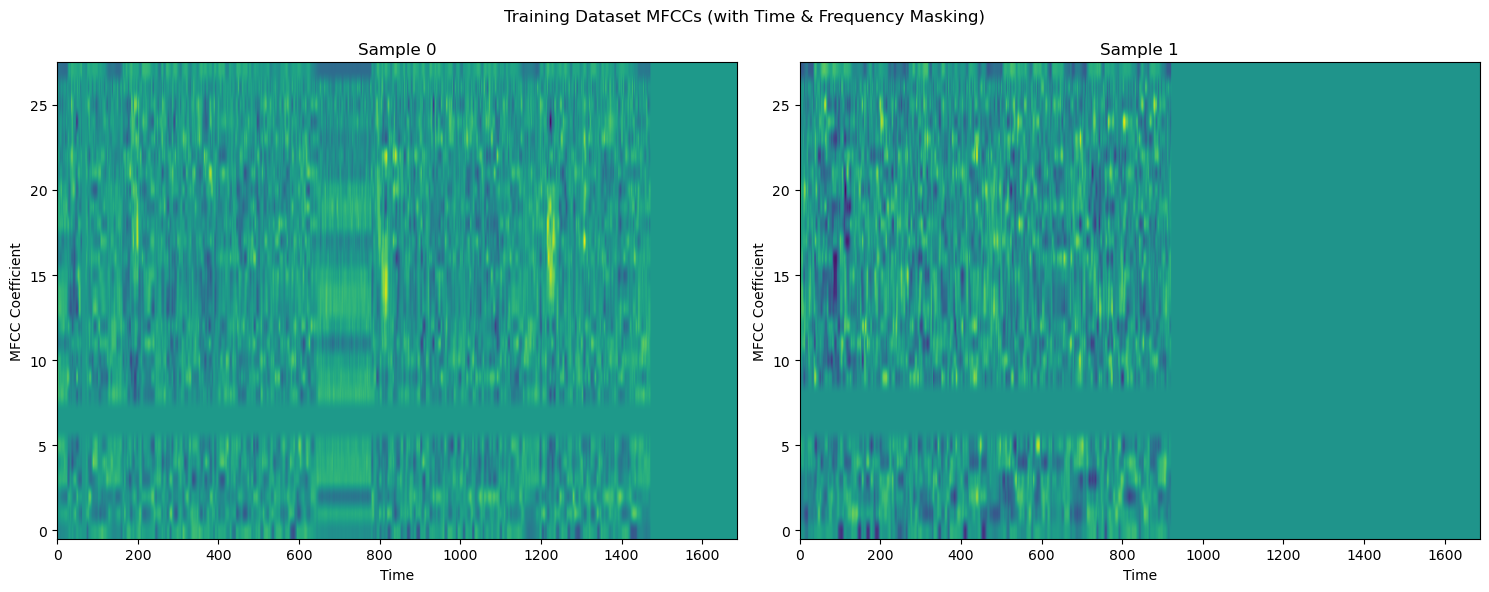

In [14]:
import matplotlib.pyplot as plt

def visualize_batch(loader, title="Dataset Visualization", num_samples=2):
    """
    Visualizes MFCC features from a single batch of data.

    Args:
        loader (DataLoader): DataLoader object (for train, val, or test).
        title (str): Title of the plot.
        num_samples (int): Number of samples to visualize from the batch.
    """
    # Get one batch from the loader.
    batch = next(iter(loader))

    # The collate_fn we defined in the dataset class returns a tuple, where the first element is the padded MFCC tensor.
    mfcc_batch = batch[0] if isinstance(batch, (tuple, list)) else batch

    # Limit to a few samples.
    num_samples = min(num_samples, mfcc_batch.size(0))

    # Create subplots.
    fig, axes = plt.subplots(1, num_samples, figsize=(15,6))
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        # Each MFCC tensor is of shape [time, frequency].
        # Transpose for visualization: time on x-axis, features on y-axis.
        mfcc_img = mfcc_batch[i].cpu().numpy().T
        im = axes[i].imshow(mfcc_img, origin="lower", aspect="auto", cmap="viridis")
        axes[i].set_title(f"Sample {i}")
        axes[i].set_xlabel("Time")
        axes[i].set_ylabel("MFCC Coefficient")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize batches of data
visualize_batch(train_loader, title="Training Dataset MFCCs (with Time & Frequency Masking)")


# Network

## Basic network (Optional)

This is a basic block for understanding, you can skip this and move to pBLSTM one

In [15]:
torch.cuda.empty_cache()

class Network(nn.Module):

    def __init__(self):

        super(Network, self).__init__()

        # TODO: Adding some sort of embedding layer or feature extractor might help performance.
        # You can use CNNs as Embedding layer to extract features. Keep in mind the Input dimensions and expected dimension of Pytorch CNN.
        # Food for thought -> What type of Conv layers can be used here?
        #                  -> What should be the size of input channels to the first layer?
        self.embedding = nn.Conv1d(in_channels=config['input_size'], out_channels=config['embed_size'], kernel_size=3, stride=1, padding=1)

        # TODO : look up the documentation. You might need to pass some additional parameters.
        self.lstm = nn.LSTM(input_size = config['input_size'], hidden_size = config['embed_size'], num_layers = 1) #TODO

        self.classification = nn.Sequential(
            nn.Linear(config['embed_size']  , 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, OUT_SIZE),
            #TODO: Linear layer with in_features from the lstm module above and out_features = OUT_SIZE
        )


        self.logSoftmax = nn.LogSoftmax(dim=2)

    def forward(self, x, lx):   
        x = self.embedding(x)
        x = self.lstm(x)
        x = self.classification(x)
        x = self.logSoftmax(x)
        return x
        #TODO
        # The forward function takes 2 parameter inputs here. Why?
        # Refer to the handout for hints


## Initialize Basic Network
(If trying out the basic Network)

In [16]:
torch.cuda.empty_cache()

model = Network().to(device)
# Check to stay below 20 MIL Parameter limit
assert sum(p.numel() for p in model.parameters() if p.requires_grad) < 20_000_000, "Exceeds 20 MIL params. Any submission made to Kaggle with this model will be flagged as an AIV."

print(model)

Network(
  (embedding): Conv1d(28, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm): LSTM(28, 256)
  (classification): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=41, bias=True)
  )
  (logSoftmax): LogSoftmax(dim=2)
)



## ASR Network
We define everything we need for the ASR model in separate classes, and put them all together in the end

#### Permute class

In [17]:
class Permute(torch.nn.Module):
    '''
    Used to transpose/permute the dimensions of an MFCC tensor.
    '''
    def forward(self, x):
        return x.transpose(1, 2)

#### Pyramidal Bi-LSTM (pBLSTM) class

In [18]:
class pBLSTM(torch.nn.Module):

    '''
    Pyramidal BiLSTM
    Read the write up/paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed (Unpack it)
    2. Reduce the input length dimension by concatenating feature dimension
        (Tip: Write down the shapes and understand)
        (i) How should  you deal with odd/even length input?
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.blstm = nn.LSTM(
            input_size=input_size * 2,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )

    def forward(self, x_packed): # x_packed is a PackedSequence

        # TODO: Pad Packed Sequence
        x_unpacked, x_lens = pad_packed_sequence(x_packed, batch_first=True)

        # TODO: Call self.trunc_reshape() which downsamples the time steps of x and increases the feature dimensions as mentioned above
        # self.trunc_reshape will return 2 outputs. What are they? Think about what quantites are changing.
        x, x_lens = self.trunc_reshape(x_unpacked, x_lens)
        # TODO: Pack Padded Sequence. What output(s) would you get?
        x_packed = pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False) 
        # TODO: Pass the sequence through bLSTM
        x_packed, _ = self.blstm(x_packed)
        
        # What do you return?

        return x_packed

    def trunc_reshape(self, x, x_lens):

        # TODO: If you have odd number of timesteps, how can you handle it? (Hint: You can exclude them)
        # Truncate to even number of timesteps
        B, T, F = x.shape
        if T % 2 == 1:
            x = x[:, :-1, :]
            x_lens = x_lens - 1
        
        # TODO: Reshape x. When reshaping x, you have to reduce number of timesteps by a downsampling factor while increasing number of features by the same factor
        x = x.reshape(B, T // 2, 2 * F)

        
        # TODO: Reduce lengths by the same downsampling factor
        x_lens = x_lens // 2

        return x, x_lens

#### Util for LSTM


In [19]:
class LSTMWrapper(torch.nn.Module):
    '''
    Used to get only output of lstm, not the hidden states.
    '''
    def __init__(self, lstm):
        super(LSTMWrapper, self).__init__()
        self.lstm = lstm

    def forward(self, x):
        output, _ = self.lstm(x)
        return output

#### Encoder class

In [20]:
class Encoder(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''
    def __init__(self, input_size, encoder_hidden_size):
        super(Encoder, self).__init__()


        # TODO: You can use CNNs as Embedding layer to extract features. Keep in mind the Input dimensions and expected dimension of Pytorch CNN.
        # Food for thought -> What type of Conv layers can be used here?
        #                  -> What should be the size of input channels to the first layer?
        self.embedding = nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=3, stride=1, padding=1)

        # TODO:
        self.BLSTMs = nn.LSTM(
            # TODO: Look up the documentation. You might need to pass some additional parameters.
            input_size=128,
            hidden_size=encoder_hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
          )

        self.pBLSTMs = torch.nn.Sequential( # How many pBLSTMs are required?
            # TODO: Fill this up with pBLSTMs - What should the input_size be?
            # Hint: You are downsampling timesteps by a factor of 2, upsampling features by a factor of 2 and the LSTM is bidirectional)
            # Optional: Dropout/Locked Dropout after each pBLSTM (Not needed for early submission)
            # https://github.com/salesforce/awd-lstm-lm/blob/dfd3cb0235d2caf2847a4d53e1cbd495b781b5d2/locked_dropout.py#L5
            # ...
            pBLSTM(input_size=2*encoder_hidden_size, hidden_size=encoder_hidden_size),  # 512 input (2*256)
            pBLSTM(input_size=2*encoder_hidden_size, hidden_size=encoder_hidden_size),  # 512 input (2*256)
            pBLSTM(input_size=2*encoder_hidden_size, hidden_size=encoder_hidden_size),  # 512 input (2*256)
            
            # ...

        )

    def forward(self, x, x_lens):
        # Where are x and x_lens coming from? The dataloader

        # TODO: Call the embedding layer
        x=x.transpose(1, 2)
        x=self.embedding(x)
        x=x.transpose(1, 2)

        # TODO: Pack Padded Sequence
        x_packed=pack_padded_sequence(x, x_lens.cpu(), batch_first=True, enforce_sorted=False)
        # TODO: Pass Sequence through the Bi-LSTM layer
        x_packed, _ = self.BLSTMs(x_packed)
        # TODO: Pass Sequence through the pyramidal Bi-LSTM layer
        for layer in self.pBLSTMs:
            x_packed = layer(x_packed)
        # TODO: Pad Packed Sequence

        # Remember the number of output(s) each function returns
        
        # Pack the sequence before passing to pBLSTMs (lengths need to be on CPU)
        x_unpacked, _ = pad_packed_sequence(x_packed, batch_first=True)

        # After 3 pBLSTMs, the time dimension is reduced by 8×
        x_lens = x_lens // (2 ** len(self.pBLSTMs))
        # Clamp to ensure lengths are at least 1 (avoid errors with very short sequences)
        x_lens = torch.clamp(x_lens, min=1)

        return x_unpacked, x_lens

#### Decoder class

In [21]:
class Decoder(torch.nn.Module):

    def __init__(self, embed_size, output_size= 41):
        super().__init__()

        self.mlp = torch.nn.Sequential(

            Permute(),
            torch.nn.BatchNorm1d(2 * embed_size),
            Permute(),

            #TODO define your MLP arch. Refer HW1P2
            #Use Permute Block before and after BatchNorm1d() to match the size
            #Now you can stack your MLP layers
            nn.Linear(2 * embed_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, output_size),
        )

        self.softmax = torch.nn.LogSoftmax(dim=2)


    def forward(self, encoder_out):

        #TODO: Call your MLP

        #TODO: Think about what should be the final output of the decoder for classification
        out = self.mlp(encoder_out)
        out = self.softmax(out)
        return out

#### ASR Model Class

In [22]:
class ASRModel(torch.nn.Module):

    def __init__(self, input_size, embed_size= 192, output_size= len(PHONEMES)):
        super().__init__()

        # Initialize encoder and decoder
        self.encoder        = Encoder(input_size, embed_size)
        self.decoder        = Decoder(embed_size, output_size)


    def forward(self, x, lengths_x):

        encoder_out, encoder_lens   = self.encoder(x, lengths_x)
        decoder_out                 = self.decoder(encoder_out)

        return decoder_out, encoder_lens

## Initialize ASR Network

In [23]:
model = ASRModel(
    input_size  = config['input_size'],
    embed_size  = config['embed_size'],
    output_size = len(PHONEMES)
).to(device)

# Check to stay below 20 MIL Parameter limit
assert sum(p.numel() for p in model.parameters() if p.requires_grad) < 20_000_000, "Exceeds 20 MIL params. Any submission made to Kaggle with this model will be flagged as an AIV."

In [24]:
summary(model, input_data=[x.to(device), lx.to(device)])

Layer (type:depth-idx)                   Output Shape              Param #
ASRModel                                 [128, 209, 41]            --
├─Encoder: 1-1                           [128, 209, 512]           --
│    └─Conv1d: 2-1                       [128, 128, 1677]          10,880
│    └─LSTM: 2-2                         [160287, 512]             2,367,488
│    └─Sequential: 2-3                   --                        --
│    │    └─pBLSTM: 3-1                  [80052, 512]              2,625,536
│    │    └─pBLSTM: 3-2                  [39992, 512]              2,625,536
│    │    └─pBLSTM: 3-3                  [19901, 512]              2,625,536
├─Decoder: 1-2                           [128, 209, 41]            --
│    └─Sequential: 2-4                   [128, 209, 41]            --
│    │    └─Permute: 3-4                 [128, 512, 209]           --
│    │    └─BatchNorm1d: 3-5             [128, 512, 209]           1,024
│    │    └─Permute: 3-6                 [128, 209

# Training Config
Initialize Loss Criterion, Optimizer, CTC Beam Decoder, Scheduler, Scaler (Mixed-Precision), etc

In [25]:
#load a checkpoint /home/agcheria/idl_assignment_Fall_2025_1/checkpoints/checkpoint-best-model.pth
checkpoint = torch.load('/home/agcheria/idl_assignment_Fall_2025_1/checkpoints/checkpoint-best-model.pth')
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [26]:
# TODO: Define CTC loss as the criterion. How would the losses be reduced?
criterion = nn.CTCLoss(
    blank=BLANK_IDX,      # your "" token index
    reduction="mean",
    zero_infinity=True
)
# CTC Loss: https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html
# Refer to the handout for hints

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config["learning_rate"],
    betas=(0.9, 0.98),
    eps=1e-9,
    weight_decay=1e-2
) #TODO: What goes in here?

# TODO: Declare the decoder. Use the PyTorch Cuda CTC Decoder to decode phonemes
# CTC Decoder: https://pytorch.org/audio/2.1/generated/torchaudio.models.decoder.cuda_ctc_decoder.html
decoder = cuda_ctc_decoder(
    tokens=LABELS,                         # same class order as the network output
    nbest=1,
    beam_size=config["train_beam_width"],
    blank_skip_threshold=0.95
) #TODO

# TODO:
steps_per_epoch = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=config["learning_rate"],
    epochs=config["epochs"],
    steps_per_epoch=steps_per_epoch,
    pct_start=0.1,
    anneal_strategy="cos"
)

# Mixed Precision, if you need it
scaler = torch.cuda.amp.GradScaler()

### Decode Prediction

In [27]:
@torch.no_grad()
def decode_prediction(output, output_lens, decoder, PHONEME_MAP = LABELS):

    # Look at docs for CUDA_CTC_DECODER for more info on how it was used here:
    # https://pytorch.org/audio/main/tutorials/asr_inference_with_cuda_ctc_decoder_tutorial.html
    output = output.contiguous()
    output_lens = output_lens.to(torch.int32).contiguous()
    beam_results = decoder(output, output_lens.to(torch.int32)) #lengths - list of lengths

    pred_strings = []

    for i in range(len(beam_results)):
        # Robustly handle different decoder return types
        hyp0 = beam_results[i][0]
        
        # Try attribute access first, then dict-like access
        tokens = getattr(hyp0, "tokens", None)
        if tokens is None:
            tokens = hyp0.get("tokens", None) if hasattr(hyp0, "get") else None
        
        # Convert to list if it's a tensor
        if torch.is_tensor(tokens):
            tokens = tokens.tolist()
        
        # Map the sequence of indices to actual phoneme LABELS and join them into a string
        pred_strings.append("".join(PHONEME_MAP[t] for t in tokens))
    return pred_strings

def calculate_levenshtein(output, label, output_lens, label_lens, decoder, PHONEME_MAP= LABELS): # y - sequence of integers

    dist            = 0
    batch_size      = label.shape[0]

    pred_strings    = decode_prediction(output, output_lens, decoder, PHONEME_MAP)

    for i in range(batch_size):
        # Truncate labels by their true lengths (not padded length)
        Li = int(label_lens[i].item())
        lab = label[i, :Li].tolist()
        label_string = "".join(PHONEME_MAP[t] for t in lab)
        pred_string = pred_strings[i]

        dist += Levenshtein.distance(pred_string, label_string)

    # Average the distance over the batch
    dist /= batch_size # Think about why we are doing this
    return dist

In [28]:
torch.cuda.empty_cache()
gc.collect()

630

## Test Implementation

In [29]:
model.eval()
for i, data in enumerate(val_loader, 0):
    x, y, lx, ly = data
    x, y = x.to(device), y.to(device)
    lx, ly = lx.to(device), ly.to(device)
    h, lh = model(x, lx)
    print(h.shape)
    h = torch.permute(h, (1, 0, 2))
    print(h.shape, y.shape)
    loss = criterion(h, y, lh, ly)
    print(loss)

    print(calculate_levenshtein(torch.permute(h, (1, 0, 2)), y, lh.to(device), ly, decoder, LABELS))

    del x, y, lx, ly, h, lh, loss
    torch.cuda.empty_cache()

    break

torch.Size([128, 210, 41])
torch.Size([210, 128, 41]) torch.Size([128, 231])
tensor(0.0129, device='cuda:0', grad_fn=<MeanBackward0>)
27.453125


## WandB

# Training Functions

In [30]:
# Train function
def train_model(model, train_loader, criterion, optimizer):

    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    total_loss = 0

    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        x, y, lx, ly = data
        x, y = x.to(device), y.to(device)
        lx, ly = lx.to(device), ly.to(device)

        with torch.cuda.amp.autocast():
            h, lh = model(x, lx)
            h = torch.permute(h, (1, 0, 2))
            loss = criterion(h, y, lh, ly)

        total_loss += loss.item()

        batch_bar.set_postfix(
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            lr="{:.06f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        
        # Gradient clipping for stability
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update() # This is something added just for FP16
        
        # Step scheduler per batch for OneCycleLR
        scheduler.step()

        del x, y, lx, ly, h, lh, loss
        torch.cuda.empty_cache()

    batch_bar.close() # You need this to close the tqdm bar

    return total_loss / len(train_loader)


# Eval function
def validate_model(model, val_loader, decoder, phoneme_map= LABELS):

    model.eval()
    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    total_loss = 0
    vdist = 0

    for i, data in enumerate(val_loader):

        x, y, lx, ly = data
        x, y = x.to(device), y.to(device)
        lx, ly = lx.to(device), ly.to(device)

        with torch.inference_mode():
            h, lh = model(x, lx)
            h = torch.permute(h, (1, 0, 2))
            loss = criterion(h, y, lh, ly)

        total_loss += loss.item()
        vdist += calculate_levenshtein(torch.permute(h, (1, 0, 2)), y, lh.to(device), ly, decoder, phoneme_map)

        batch_bar.set_postfix(loss="{:.04f}".format(float(total_loss / (i + 1))), dist="{:.04f}".format(float(vdist / (i + 1))))

        batch_bar.update()

        del x, y, lx, ly, h, lh, loss
        torch.cuda.empty_cache()

    batch_bar.close()
    total_loss = total_loss/len(val_loader)
    val_dist = vdist/len(val_loader)
    return total_loss, val_dist

### Model Saving & Loading functions

In [31]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict() if scheduler is not None else {},
         metric[0]                  : metric[1],
         'epoch'                    : epoch},
         path
    )
    print(f"✓ Checkpoint saved locally to: {path}")

def load_model(path, model, optimizer= None, scheduler= None, metric='valid_dist'):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    epoch   = checkpoint['epoch']
    metric  = checkpoint[metric]

    print("\nResuming training from epoch:", epoch)
    print('----------------------------------------\n')
    print("Epochs left: ", config['epochs'] - epoch)
    print("Optimizer: \n", optimizer)
    print("Current Schedueler T_cur:", scheduler.T_cur)

    print("Best Val Dist:", metric)

    return [model, optimizer, scheduler, epoch, metric]

## Training Loop

In [32]:
# Instantiate variables used in training loop
last_epoch_completed = 0
best_lev_dist = float("inf")

#### Uncomment this if resuming training from model checkpoint

In [33]:
# RESUME_TRAINING = True # Set this to true if you are resuming training from a mpdel checkpoint

# if RESUME_TRAINING:

#     checkpoint_path = ''
#     checkpoint = load_model(checkpoint_path, model, optimizer, scheduler, metric='valid_dist')

#     last_epoch_completed = checkpoint[3]
#     best_lev_dist = checkpoint[4]

In [34]:
# Clear RAM for storage before you start training
torch.cuda.empty_cache()
gc.collect()

0

#### Iterate over the number of epochs to train and evaluate your model


# Generate Predictions and Submit to Kaggle

In [35]:
#TODO: Make predictions

# Follow the steps below:
# 1. Create a new object for CUDA_CTC_DECODER with larger number of beams (why larger?)
# 2. Get prediction string by decoding the results of the beam decoder


test_decoder = cuda_ctc_decoder(
    tokens=LABELS,
    nbest=1,
    beam_size=3,  
    blank_skip_threshold=0.95
)

model.eval()
torch.backends.cudnn.benchmark = True  # speed up conv/LSTM for fixed shapes

results = []
with torch.inference_mode():
    for i, (x, lx) in enumerate(tqdm(test_loader)):
        x  = x.to(device, non_blocking=True)
        lx = lx.to(device, non_blocking=True)

        h, lh = model(x, lx)                    # h: (B, T, C) log-probs; lh: (B,)
        
        preds = decode_prediction(h, lh, test_decoder, LABELS)
        results.extend(preds)
        
        # Clear memory after each batch
        del x, lx, h, lh
        torch.cuda.empty_cache()          

100%|██████████| 21/21 [00:02<00:00,  7.42it/s]


In [36]:
if results:
    df = pd.DataFrame({
        'index': range(len(results)), 'label': results
    })

data_dir = "submission.csv"
df.to_csv(data_dir, index = False)

- You will need to set the save path to your `submission.csv`. This will depend on your setup. For eg.
  - `Colab:`: `"/content/..."` or `"/content/drive/MyDrive/..."`
  - `Kaggle:`: `"/kaggle/working/..."`
  - `PSC`: `"/jet/home/<your_username>/..."`

#### TODO: Generate a model_metadata.json file to save your model's data (due 48 hours after Kaggle submission deadline OR the day of slack submission)